Projemiz için kutuphaneleri yükliyelim

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

Verilerimizin Yolunu verelim

In [2]:
Train_root = "/Users/abdulbarisoylemez/Desktop/ExplainableShoesProject/Shoes/train"
Test_root = "/Users/abdulbarisoylemez/Desktop/ExplainableShoesProject/Shoes/test"

PyTorch modelinizi eğitmek için hangi cihazın kullanılacağını belirlerleyelim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Kullanılan cihaz:", device)

Kullanılan cihaz: cpu


Veri ön işleme yapalım


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
Train_dataset = ImageFolder(root=Train_root, transform=transform)
Test_dataset = ImageFolder(root=Test_root, transform=transform)


Model oluşturalım 

In [6]:
# Model oluşturma
model = resnet50(pretrained=True)
model.fc = nn.Linear(2048, len(Train_dataset.classes))  # Sınıf sayısına göre çıkış katmanını ayarla
model.to(device)

/Users/abdulbarisoylemez/anaconda3/envs/explainable/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/abdulbarisoylemez/anaconda3/envs/explainable/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

veri kümesini yükleyelim ve bir mini grup (batch) oluşturalım

In [7]:
batch_size=32
Train_loader = DataLoader(Train_dataset, batch_size=batch_size, shuffle=True)
Test_loader = DataLoader(Test_dataset, batch_size=batch_size, shuffle=True)


kayıp fonksiyonunu ve optimizer'ı tanımlayalım

In [8]:
cross = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.0001)

GradCAM modelimizin hangi bölgelerin sınıf tahminlerinde en etkili olduğunu görselleştirmek için kullanılabilir.

In [9]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

Model eğitimine geçelim

In [10]:
epochs=30
for epoch in range(epochs):
    start_time = time.time()
    
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(Train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = cross(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    
    # Epoch süresini ve kayıp değerini kulnıcıya gösterelim
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds. Loss val: {running_loss / 10:.5f}")
    

/Users/abdulbarisoylemez/anaconda3/envs/explainable/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 completed in 172.32 seconds. Loss val: 1.86156
Epoch 2 completed in 173.26 seconds. Loss val: 0.32950
Epoch 3 completed in 171.23 seconds. Loss val: 0.16614
Epoch 4 completed in 169.81 seconds. Loss val: 0.07152
Epoch 5 completed in 173.26 seconds. Loss val: 0.14998
Epoch 6 completed in 177.06 seconds. Loss val: 0.03999
Epoch 7 completed in 179.05 seconds. Loss val: 0.03911
Epoch 8 completed in 178.32 seconds. Loss val: 0.04176
Epoch 9 completed in 167.18 seconds. Loss val: 0.02310
Epoch 10 completed in 173.03 seconds. Loss val: 0.03604
Epoch 11 completed in 184.73 seconds. Loss val: 0.01949
Epoch 12 completed in 170.53 seconds. Loss val: 0.01696
Epoch 13 completed in 177.78 seconds. Loss val: 0.17068
Epoch 14 completed in 179.96 seconds. Loss val: 0.08848
Epoch 15 completed in 181.61 seconds. Loss val: 0.02039
Epoch 16 completed in 193.36 seconds. Loss val: 0.01693
Epoch 17 completed in 194.44 seconds. Loss val: 0.04327
Epoch 18 completed in 185.56 seconds. Loss val: 0.01202
E

Modeli doğruluğunu test edelim 

In [11]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Modeli değerlendirme moduna geçir
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    accuracy = correct_predictions / total_predictions
    average_loss = running_loss / len(dataloader)
    
    return accuracy, average_loss

# Modelin başarımını değerlendirme
test_accuracy, test_loss = evaluate_model(model, Test_loader, cross)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Test Accuracy: 0.8618, Test Loss: 0.3114


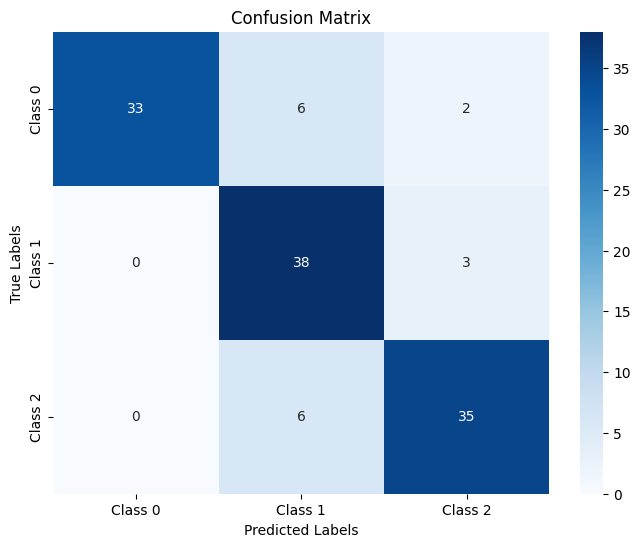

Model Doğruluğu: 0.8617886178861789


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test veri kümesinden tüm girişlerin ve etiketlerin alınması
all_inputs = []
all_labels = []

for inputs, labels in Test_loader:
    all_inputs.append(inputs)
    all_labels.append(labels.numpy())

all_inputs = torch.cat(all_inputs, dim=0)
all_labels = np.concatenate(all_labels)

# Tüm girişlerin model üzerinden geçirilmesi ve tahmin edilen çıkışların elde edilmesi
all_outputs = model(all_inputs).max(1).indices.detach().cpu().numpy()

# Confusion matrix hesaplanması
cm = confusion_matrix(all_labels, all_outputs)

# Confusion matrix'in seaborn ile görselleştirilmesi
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Doğruluk hesaplanması
accuracy = np.trace(cm) / float(np.sum(cm))
print("Model Doğruluğu:", accuracy)


Görsel üzerinde modelin hangi piksel değerlerine bakarak tespite bulunduğunu gösterelim

Predicted: 2


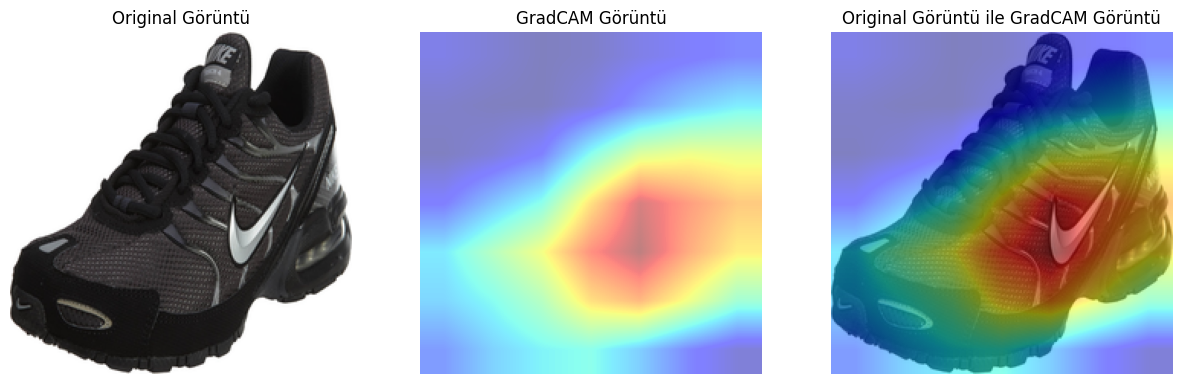

In [26]:
# Modelin tahminlerini görselleştirme
model.eval()  # Değerlendirme moduna geç

idx = 1  

images, _ = next(iter(Test_loader))  # Test veri kümesinden bir batch al
img = images[idx].unsqueeze(0).to(device)  # İlgili fotoğrafı seç ve cihaza yükle
output = model(img)  # Modelden çıktı al

# GradCAM'i kullanarak görselleştirme yapma
grayscale_cam = cam(input_tensor=img)
grayscale_cam = grayscale_cam[0, :]

# Modelin çıktılarını ve tahminlerini görme
_, predicted = torch.max(output, 1)
print(f"Predicted: {predicted.item()}")

# Görselleştirmeleri Matplotlib kullanarak görüntüleme
plt.figure(figsize=(15, 7))

# Orijinal görüntü
plt.subplot(1, 3, 1)
plt.title("Original Görüntü")
plt.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')

# GradCAM
plt.subplot(1, 3, 2)
plt.title("GradCAM Görüntü")
plt.imshow(grayscale_cam, cmap='jet', alpha=0.5)
plt.axis('off')

# Orijinal görüntü üzerine GradCAM
plt.subplot(1, 3, 3)
plt.title("Original Görüntü ile GradCAM Görüntü")
plt.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
plt.imshow(grayscale_cam, cmap='jet', alpha=0.5)
plt.axis('off')

plt.show()


Raskele 4 görsel üzerinde gösterelim ve bunu hangi değerleri doğru mu değilmi gösteren kodda çevir 

Actual Label: 2, Predicted Label: 2, Prediction: Correct


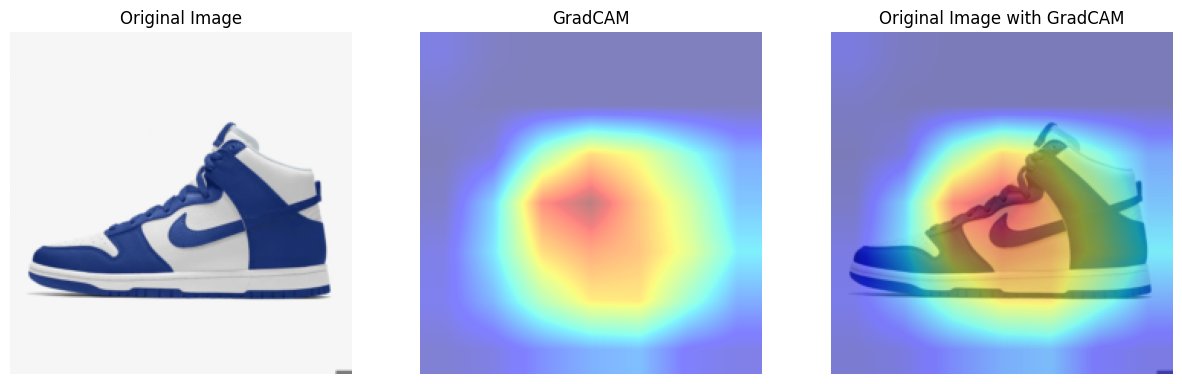

Actual Label: 2, Predicted Label: 2, Prediction: Correct


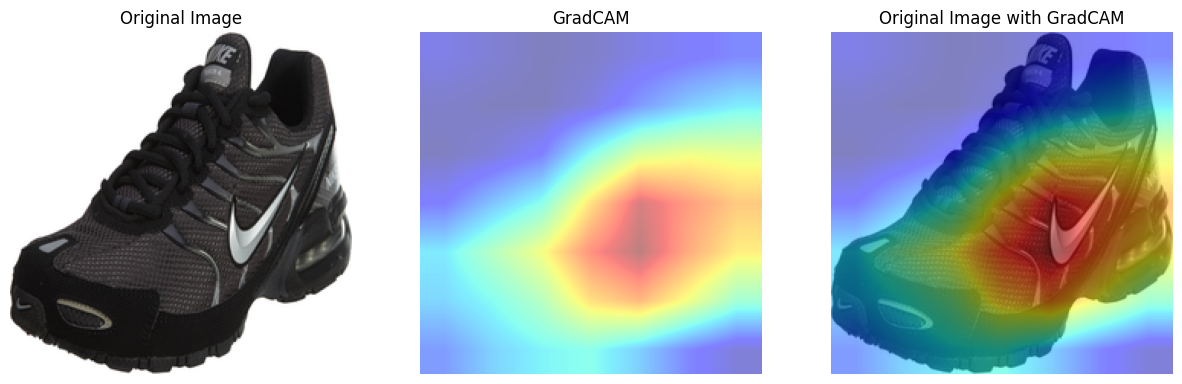

Actual Label: 1, Predicted Label: 1, Prediction: Correct


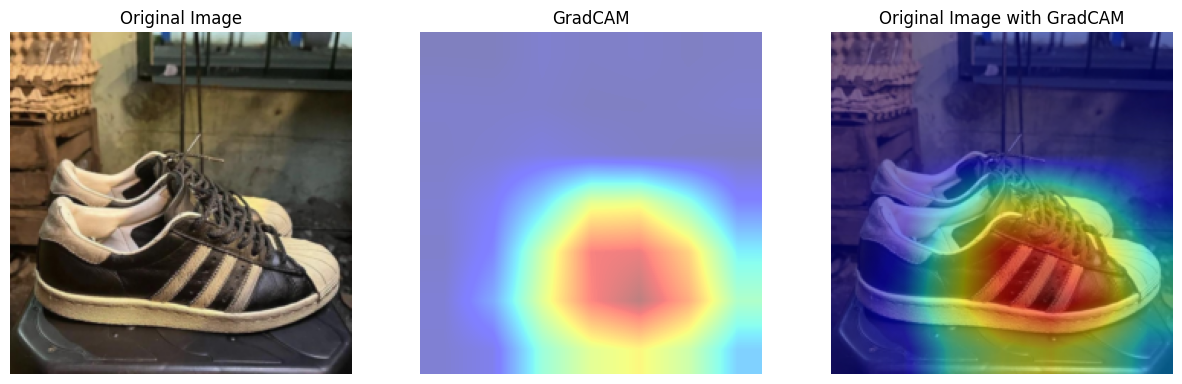

Actual Label: 0, Predicted Label: 0, Prediction: Correct


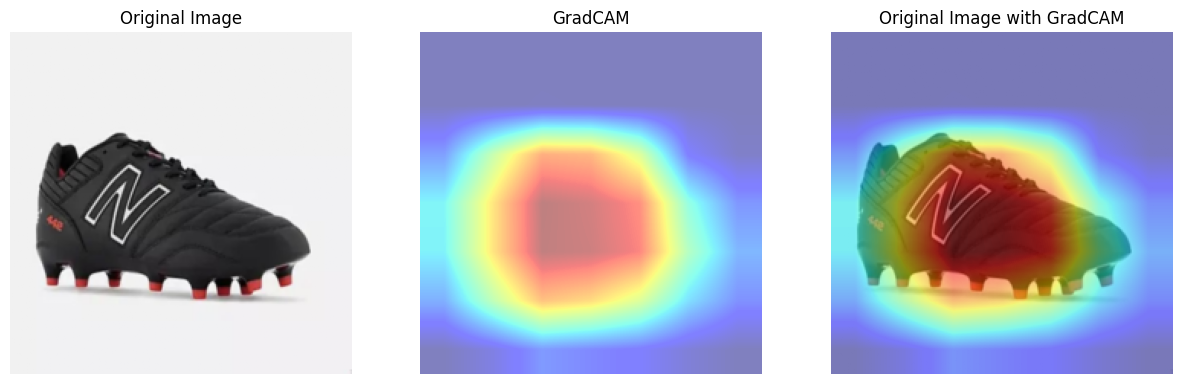

In [32]:
for idx in range(4):
    images, labels = next(iter(Test_loader))  # Test veri kümesinden bir batch al
    img = images[idx].unsqueeze(0).to(device)  # İlgili fotoğrafı seç ve cihaza yükle
    output = model(img)  # Modelden çıktı al

    # GradCAM'i kullanarak görselleştirme yapma
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]

    # Modelin çıktılarını ve tahminlerini görme
    _, predicted = torch.max(output, 1)
    actual_label = labels[idx].item()
    predicted_label = predicted.item()
    prediction_correct = "Correct" if actual_label == predicted_label else "Incorrect"
    print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}, Prediction: {prediction_correct}")

    # Görselleştirmeleri Matplotlib kullanarak görüntüleme
    plt.figure(figsize=(15, 7))

    # Orijinal görüntü
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    # GradCAM
    plt.subplot(1, 3, 2)
    plt.title("GradCAM")
    plt.imshow(grayscale_cam, cmap='jet', alpha=0.5)
    plt.axis('off')

    # Orijinal görüntü üzerine GradCAM
    plt.subplot(1, 3, 3)
    plt.title("Original Image with GradCAM")
    plt.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.imshow(grayscale_cam, cmap='jet', alpha=0.5)
    plt.axis('off')

    plt.show()
